## Evaluating Pre-Trained CNN model
<br>
<br>

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
import os
from scripts import engine,predictions,train
import matplotlib.pyplot as plt
from src.models import resnet,vgg,custom_cnn
from src.data import dataloaders,transforms
from src.utils import visualisations,save_model
from torchinfo import summary

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_WORKERS = os.cpu_count()
EPOCHS = 10

## ResNet-50

In [6]:
ResNet50, resnet50_eval_transforms = resnet.resnet50(num_classes=10)

In [7]:
resnet50_eval_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [8]:
#Unbalanced dataset
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= dataloaders.create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet50_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

#Balanced dataset
balanced_train_dir = "../data/Galaxy10_DECaLS_Balanced/train"
balanced_test_dir = "../data/Galaxy10_DECaLS_Balanced/test"

balanced_train_loader, _, balanced_test_loader, class_names= dataloaders.create_dataloaders(train_dir=balanced_train_dir, 
                                                                        test_dir=balanced_test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet50_eval_transforms,
                                                                        batch_size=BATCH_SIZE)


In [10]:
optimizer = torch.optim.Adam(params=ResNet50.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [12]:
resnet50_results = engine.train(model=ResNet50,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7421 | train_acc: 0.3977 | val_loss: 1.5684 | val_acc: 0.4602
Epoch: 2 | train_loss: 1.5085 | train_acc: 0.4733 | val_loss: 1.4888 | val_acc: 0.4678
Epoch: 3 | train_loss: 1.4459 | train_acc: 0.4854 | val_loss: 1.4560 | val_acc: 0.4821
Epoch: 4 | train_loss: 1.4177 | train_acc: 0.4958 | val_loss: 1.4016 | val_acc: 0.5163
Epoch: 5 | train_loss: 1.3935 | train_acc: 0.5027 | val_loss: 1.3872 | val_acc: 0.5131
Epoch: 6 | train_loss: 1.3836 | train_acc: 0.5036 | val_loss: 1.3720 | val_acc: 0.5231
Epoch: 7 | train_loss: 1.3832 | train_acc: 0.5042 | val_loss: 1.3485 | val_acc: 0.5296
Epoch: 8 | train_loss: 1.3666 | train_acc: 0.5120 | val_loss: 1.3462 | val_acc: 0.5429
Epoch: 9 | train_loss: 1.3680 | train_acc: 0.5141 | val_loss: 1.3272 | val_acc: 0.5525
Epoch: 10 | train_loss: 1.3602 | train_acc: 0.5077 | val_loss: 1.3417 | val_acc: 0.5479


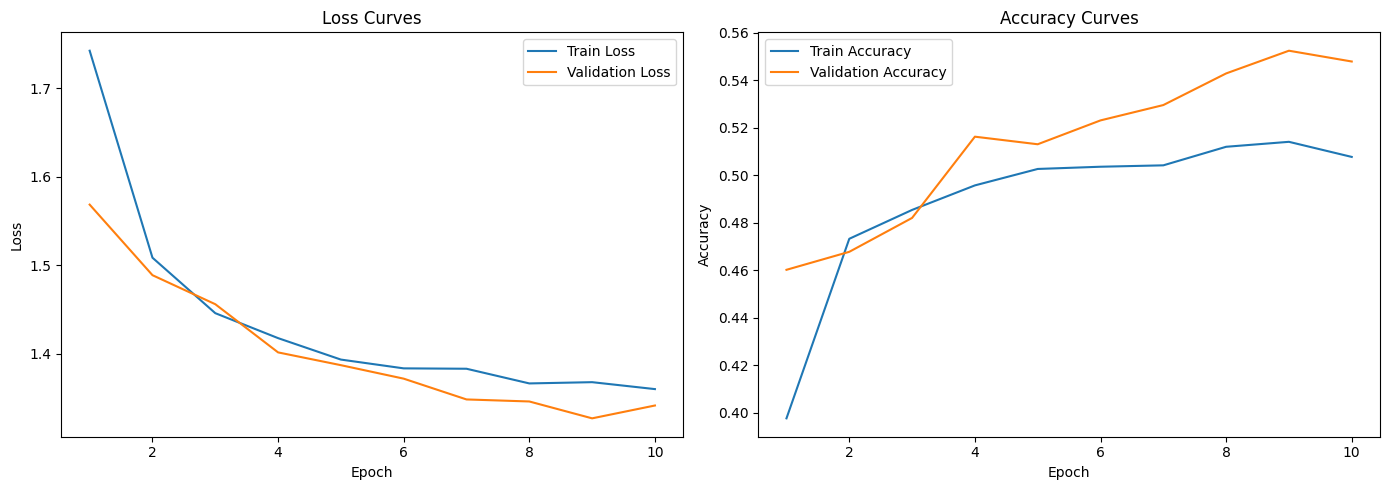

In [13]:
visualisations.plot_acc_loss_curves(results=resnet50_results,validation=True)

In [ ]:
save_model.save_model(model=ResNet50,model_name="Resnet50_10_epochs_trainable_classifier.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet50/Resnet50_10_epochs_trainable_classifier.pth


In [26]:
test_results = predictions.test_model(model=ResNet50,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5135
Test loss : 1.4031


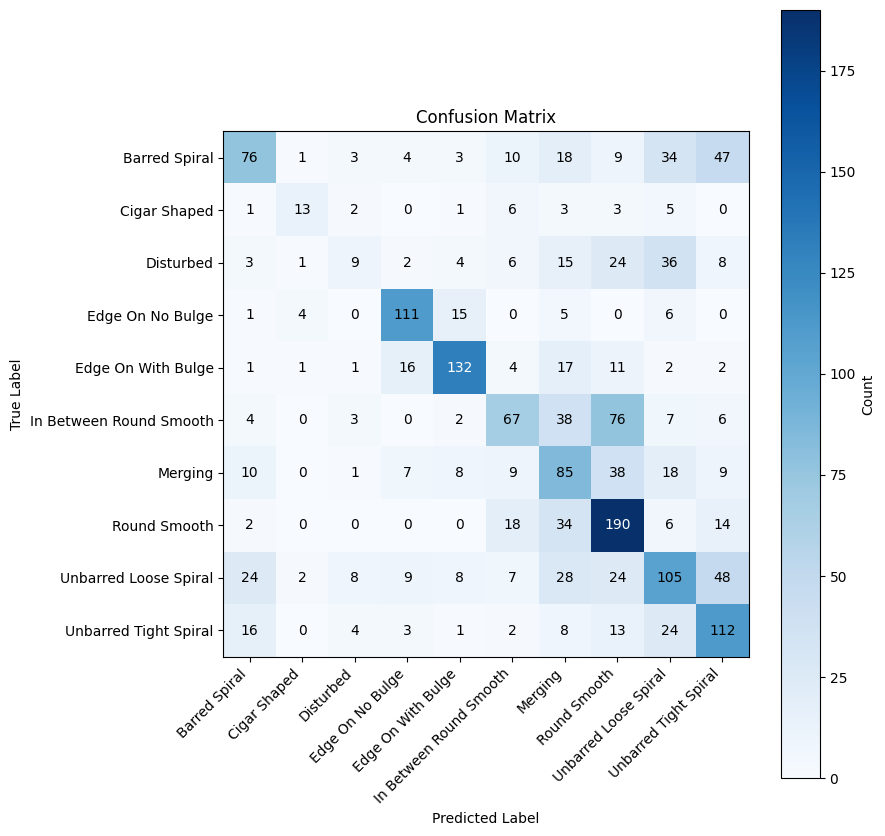

In [16]:
predictions.plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

### Training model on balanced dataset

In [19]:
ResNet50, resnet50_eval_transforms = resnet.resnet50(num_classes=10)
optimizer = torch.optim.Adam(params=ResNet50.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [20]:
resnet50_results = engine.train(model=ResNet50,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS*3,
                                train_dataloader=balanced_train_loader,
                                test_dataloader=balanced_test_loader,
                                validation=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1174 | train_acc: 0.2509 | test_loss: 1.9951 | test_acc: 0.3420
Epoch: 2 | train_loss: 1.8485 | train_acc: 0.3800 | test_loss: 1.8614 | test_acc: 0.3741
Epoch: 3 | train_loss: 1.7395 | train_acc: 0.4002 | test_loss: 1.7686 | test_acc: 0.4161
Epoch: 4 | train_loss: 1.6716 | train_acc: 0.4237 | test_loss: 1.7065 | test_acc: 0.4390
Epoch: 5 | train_loss: 1.6028 | train_acc: 0.4531 | test_loss: 1.6582 | test_acc: 0.4313
Epoch: 6 | train_loss: 1.5739 | train_acc: 0.4598 | test_loss: 1.6339 | test_acc: 0.4744
Epoch: 7 | train_loss: 1.5541 | train_acc: 0.4753 | test_loss: 1.6195 | test_acc: 0.4652
Epoch: 8 | train_loss: 1.5356 | train_acc: 0.4559 | test_loss: 1.5926 | test_acc: 0.4732
Epoch: 9 | train_loss: 1.4936 | train_acc: 0.4787 | test_loss: 1.5682 | test_acc: 0.4747
Epoch: 10 | train_loss: 1.4909 | train_acc: 0.4852 | test_loss: 1.5776 | test_acc: 0.4503
Epoch: 11 | train_loss: 1.4964 | train_acc: 0.4722 | test_loss: 1.5746 | test_acc: 0.4545
Epoch: 12 | train_l

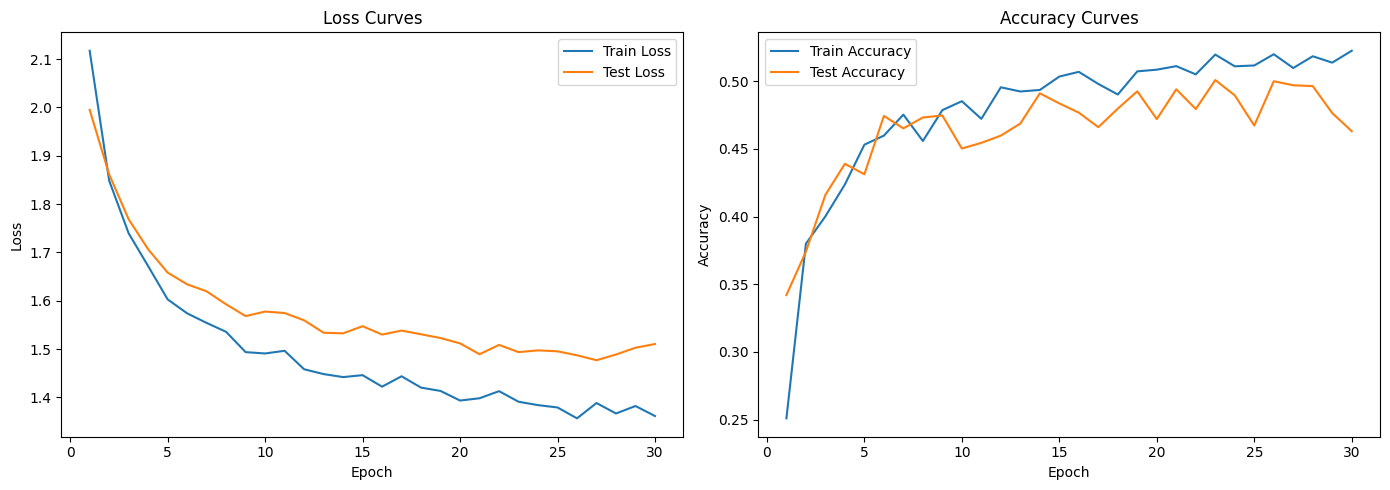

In [21]:
visualisations.plot_acc_loss_curves(results=resnet50_results,validation=False)

In [22]:
save_model.save_model(model=ResNet50,model_name="Resnet50_30_epochs_trainable_classifier_balanced_dataset.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet50/Resnet50_30_epochs_trainable_classifier_balanced_dataset.pth


In [24]:
balanced_test_results = predictions.test_model(model=ResNet50,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.4606
Test loss : 1.5156


In [25]:
test_results = predictions.test_model(model=ResNet50, #Test results on unbalanced test dataset
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.4628
Test loss : 1.5056


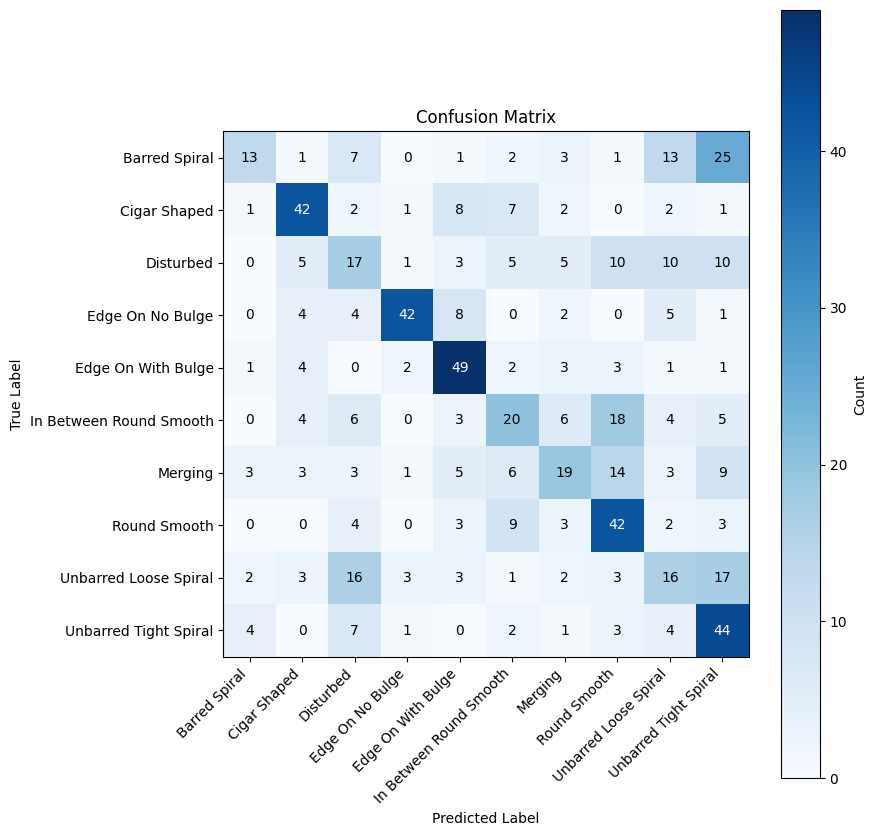

In [26]:
predictions.plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

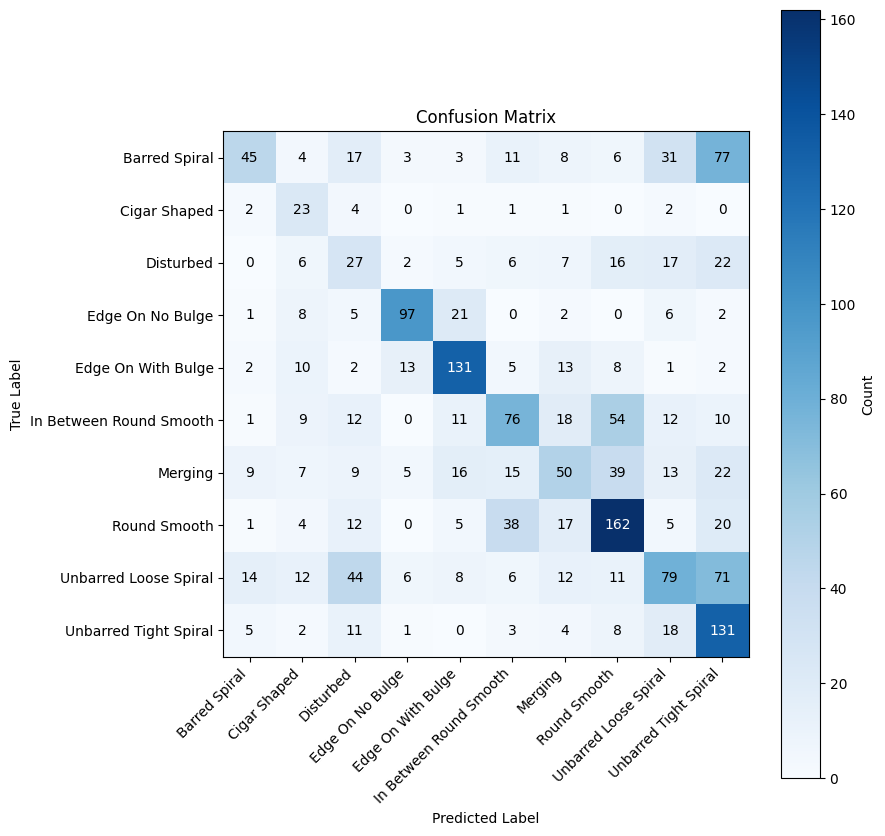

In [27]:
predictions.plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)
#Confusion matrix for unbalanced test dataset

<br>

## ResNet26

In [7]:
ResNet26, resnet26_eval_transforms = resnet.resnet26(num_classes=10)

In [8]:
resnet26_eval_transforms

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [9]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= dataloaders.create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet26_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [10]:
optimizer = torch.optim.Adam(params=ResNet26.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
resnet26_results = engine.train(model=ResNet26,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5267 | train_acc: 0.4553 | val_loss: 1.4596 | val_acc: 0.4875
Epoch: 2 | train_loss: 1.3545 | train_acc: 0.5132 | val_loss: 1.4349 | val_acc: 0.4984
Epoch: 3 | train_loss: 1.3183 | train_acc: 0.5279 | val_loss: 1.4346 | val_acc: 0.4904
Epoch: 4 | train_loss: 1.3051 | train_acc: 0.5296 | val_loss: 1.4044 | val_acc: 0.5044
Epoch: 5 | train_loss: 1.2998 | train_acc: 0.5339 | val_loss: 1.4178 | val_acc: 0.4880
Epoch: 6 | train_loss: 1.2782 | train_acc: 0.5432 | val_loss: 1.3960 | val_acc: 0.5122
Epoch: 7 | train_loss: 1.2807 | train_acc: 0.5376 | val_loss: 1.3604 | val_acc: 0.5108
Epoch: 8 | train_loss: 1.2716 | train_acc: 0.5403 | val_loss: 1.4576 | val_acc: 0.4724
Epoch: 9 | train_loss: 1.2797 | train_acc: 0.5434 | val_loss: 1.3803 | val_acc: 0.5112
Epoch: 10 | train_loss: 1.2731 | train_acc: 0.5450 | val_loss: 1.3415 | val_acc: 0.5219


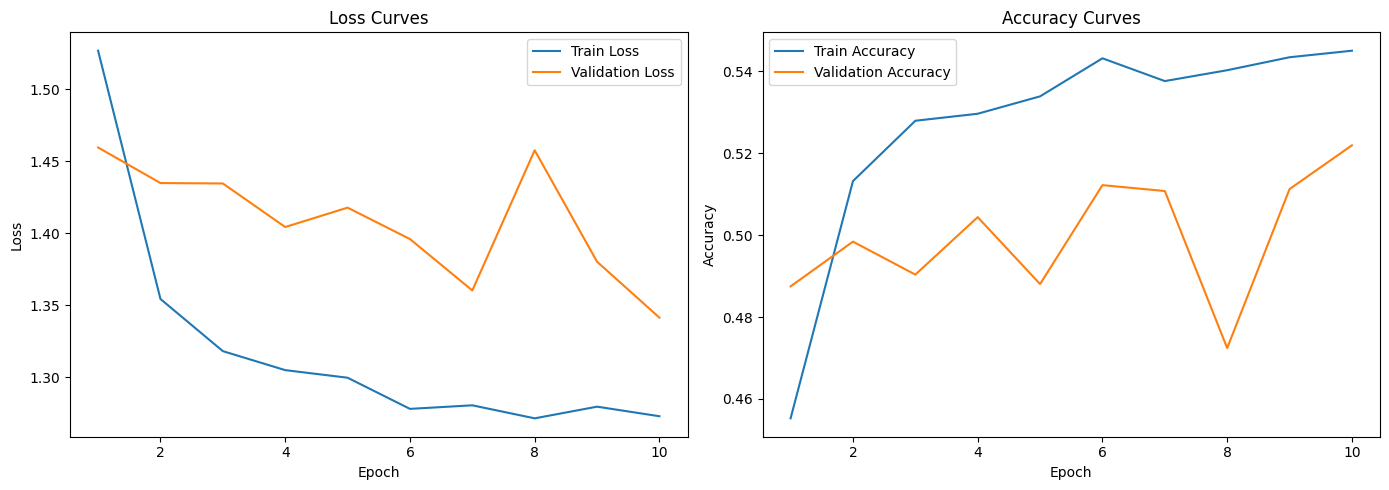

In [12]:
visualisations.plot_acc_loss_curves(results=resnet26_results,validation=True)

In [13]:
test_results = predictions.test_model(model=ResNet26,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5045
Test loss : 1.3673


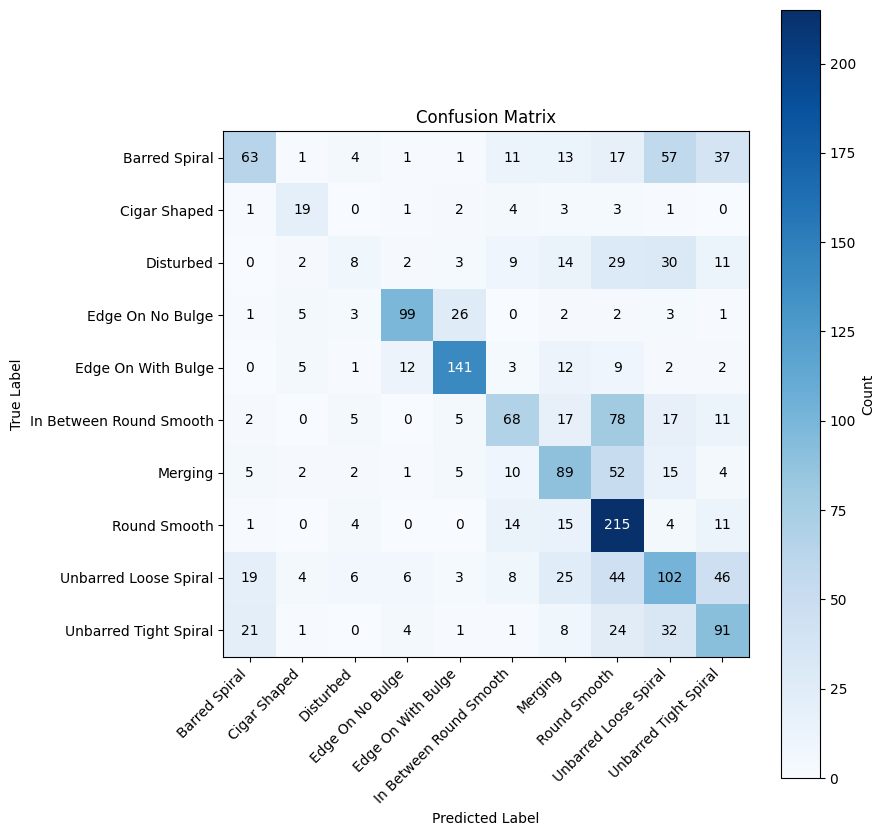

In [14]:
predictions.plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

In [15]:
save_model.save_model(model=ResNet26,model_name="Resnet26_10_epochs_trainable_classifier.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet26/Resnet26_10_epochs_trainable_classifier.pth


### Training model on balanced dataset

In [9]:
ResNet26, resnet26_eval_transforms = resnet.resnet26(num_classes=10)
optimizer = torch.optim.Adam(params=ResNet26.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [10]:
#Balanced dataset
balanced_train_dir = "../data/Galaxy10_DECaLS_Balanced/train"
balanced_test_dir = "../data/Galaxy10_DECaLS_Balanced/test"
val_dir = "../data/Galaxy10_DECaLS/val" #We're not going to use this in our balanced dataset pipeline

balanced_train_loader, _, balanced_test_loader, class_names= dataloaders.create_dataloaders(train_dir=balanced_train_dir, 
                                                                        test_dir=balanced_test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet26_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [11]:
resnet26_results = engine.train(model=ResNet26,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS*3,
                                train_dataloader=balanced_train_loader,
                                test_dataloader=balanced_test_loader,
                                validation=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8877 | train_acc: 0.3402 | test_loss: 1.8772 | test_acc: 0.3253
Epoch: 2 | train_loss: 1.5725 | train_acc: 0.4484 | test_loss: 1.7207 | test_acc: 0.3973
Epoch: 3 | train_loss: 1.4829 | train_acc: 0.4834 | test_loss: 1.6519 | test_acc: 0.3994
Epoch: 4 | train_loss: 1.4096 | train_acc: 0.4932 | test_loss: 1.6256 | test_acc: 0.4238
Epoch: 5 | train_loss: 1.3970 | train_acc: 0.5019 | test_loss: 1.5906 | test_acc: 0.4652
Epoch: 6 | train_loss: 1.3706 | train_acc: 0.5095 | test_loss: 1.5519 | test_acc: 0.4747
Epoch: 7 | train_loss: 1.3481 | train_acc: 0.5236 | test_loss: 1.5299 | test_acc: 0.4792
Epoch: 8 | train_loss: 1.3059 | train_acc: 0.5371 | test_loss: 1.5422 | test_acc: 0.4625
Epoch: 9 | train_loss: 1.2982 | train_acc: 0.5368 | test_loss: 1.5537 | test_acc: 0.4693
Epoch: 10 | train_loss: 1.2936 | train_acc: 0.5427 | test_loss: 1.5349 | test_acc: 0.4533
Epoch: 11 | train_loss: 1.2787 | train_acc: 0.5451 | test_loss: 1.5545 | test_acc: 0.4530
Epoch: 12 | train_l

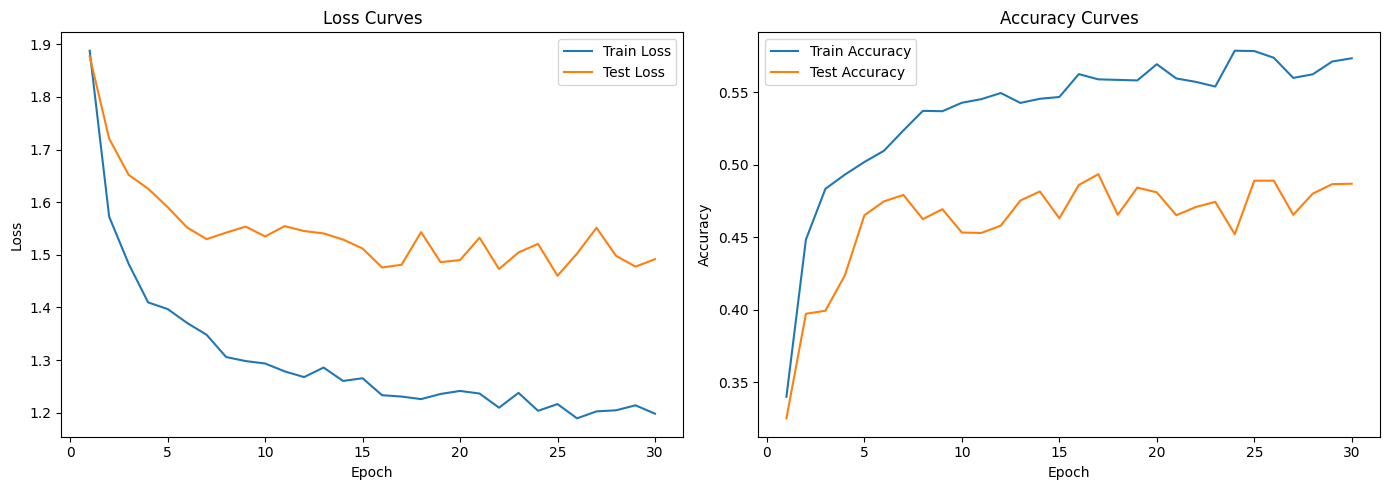

In [12]:
visualisations.plot_acc_loss_curves(results=resnet26_results,validation=False)

In [13]:
save_model.save_model(model=ResNet26,model_name="Resnet26_30_epochs_trainable_classifier_balanced_dataset.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet26/Resnet26_30_epochs_trainable_classifier_balanced_dataset.pth


In [14]:
balanced_test_results = predictions.test_model(model=ResNet26,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.4894
Test loss : 1.4860


In [16]:
test_results = predictions.test_model(model=ResNet26,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5096
Test loss : 1.3619


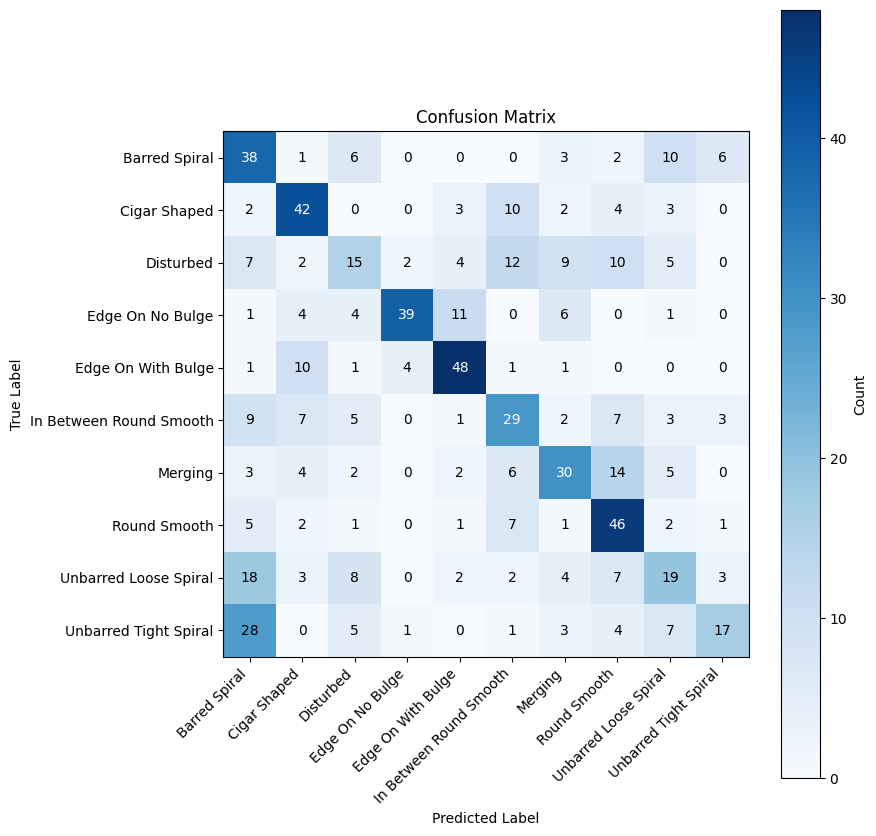

In [17]:
predictions.plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

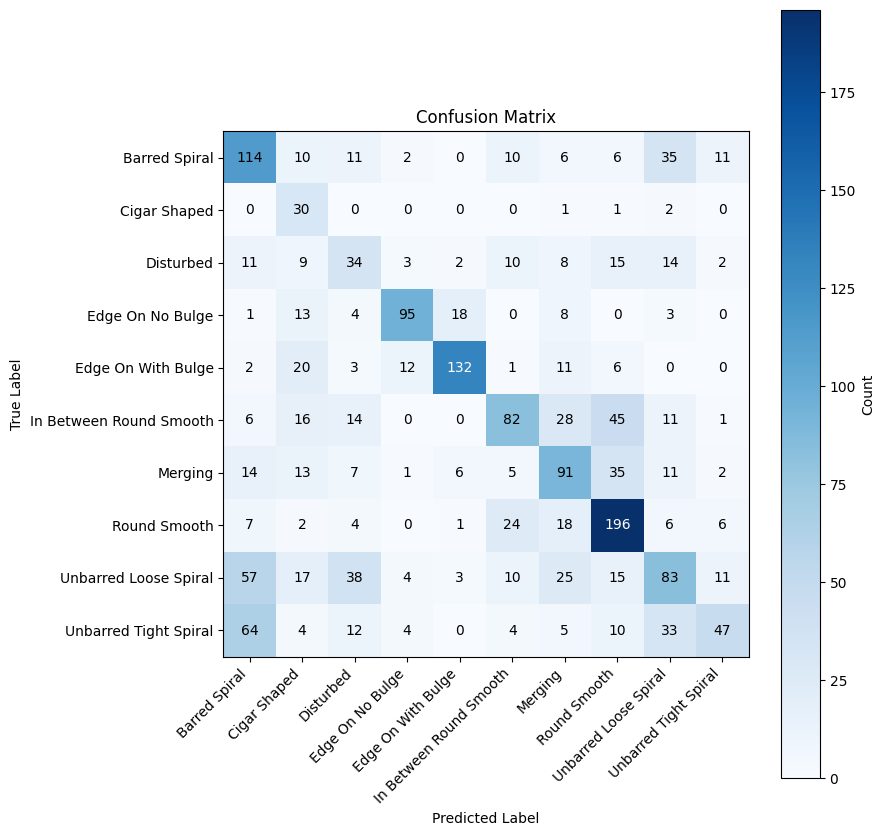

In [18]:
predictions.plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)
#Confusion matrix for unbalanced test dataset

<br>

## VGG16

In [5]:
Vgg16, vgg16_eval_transforms = vgg.vgg16(num_classes=10)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/asus/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [02:43<00:00, 3.39MB/s] 


In [16]:
vgg16_eval_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [17]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= dataloaders.create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=vgg16_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [18]:
optimizer = torch.optim.Adam(params=Vgg16.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [19]:
vgg16_results = engine.train(model=Vgg16,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6784 | train_acc: 0.3971 | val_loss: 1.3670 | val_acc: 0.4939
Epoch: 2 | train_loss: 1.4209 | train_acc: 0.4797 | val_loss: 1.3032 | val_acc: 0.5396
Epoch: 3 | train_loss: 1.3395 | train_acc: 0.5109 | val_loss: 1.2196 | val_acc: 0.5604
Epoch: 4 | train_loss: 1.3040 | train_acc: 0.5278 | val_loss: 1.3327 | val_acc: 0.5124
Epoch: 5 | train_loss: 1.2747 | train_acc: 0.5384 | val_loss: 1.1658 | val_acc: 0.6004
Epoch: 6 | train_loss: 1.2616 | train_acc: 0.5471 | val_loss: 1.1867 | val_acc: 0.5891
Epoch: 7 | train_loss: 1.2376 | train_acc: 0.5558 | val_loss: 1.1994 | val_acc: 0.5902
Epoch: 8 | train_loss: 1.2208 | train_acc: 0.5581 | val_loss: 1.1809 | val_acc: 0.5835
Epoch: 9 | train_loss: 1.2230 | train_acc: 0.5573 | val_loss: 1.1579 | val_acc: 0.5922
Epoch: 10 | train_loss: 1.2085 | train_acc: 0.5688 | val_loss: 1.1933 | val_acc: 0.5796


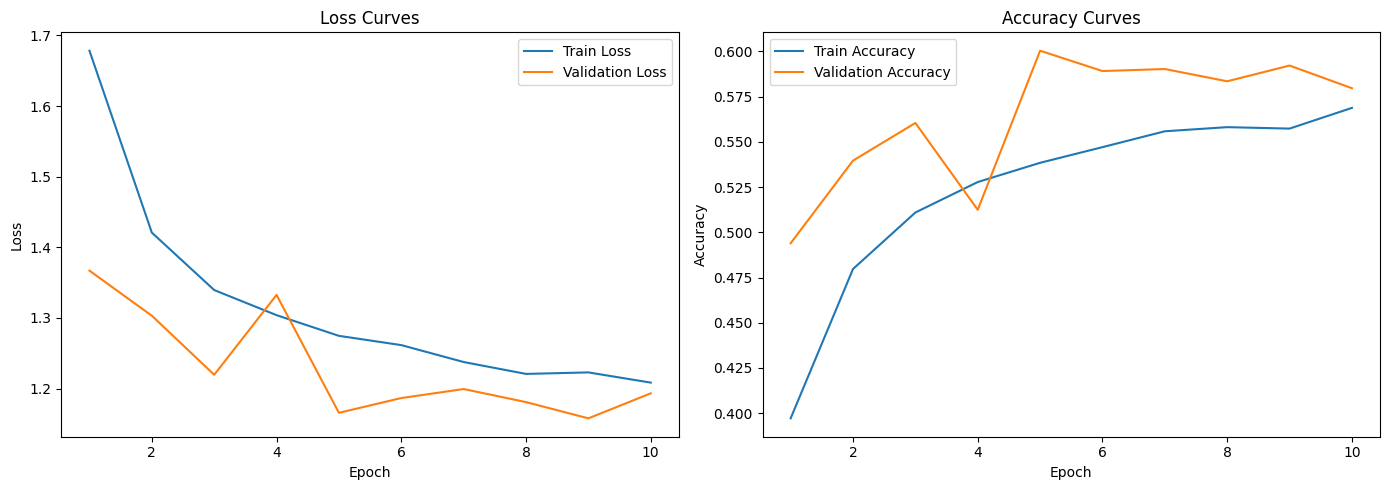

In [20]:
visualisations.plot_acc_loss_curves(results=vgg16_results,validation=True)

In [21]:
test_results = predictions.test_model(model=Vgg16,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5547
Test loss : 1.2131


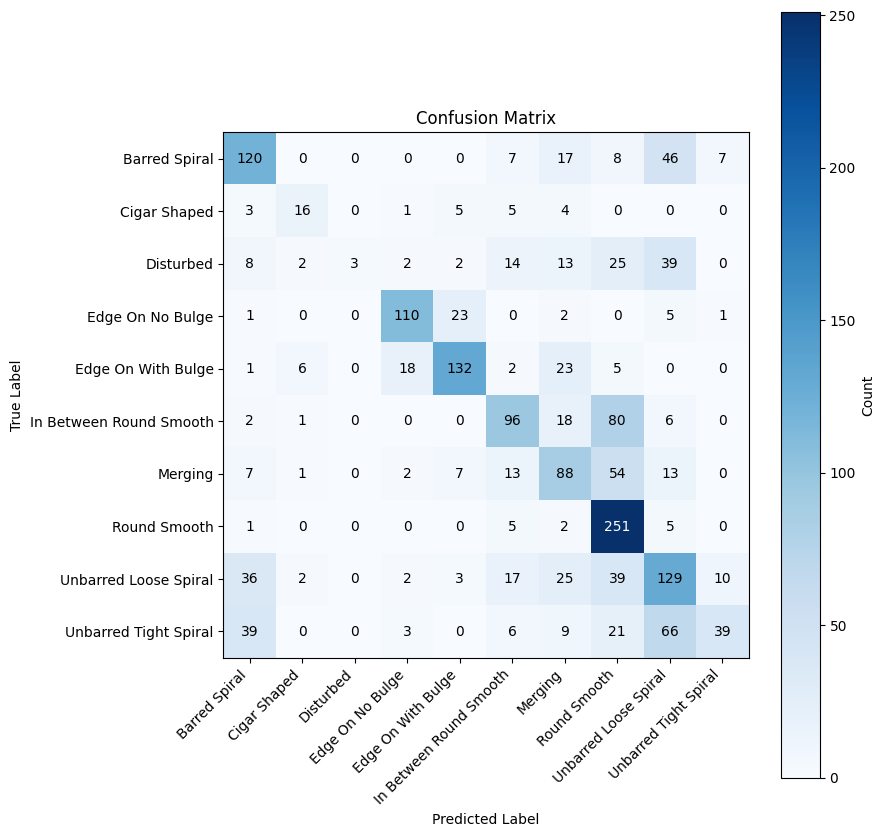

In [22]:
predictions.plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

In [23]:
save_model.save_model(model=ResNet26,model_name="VGG16_10_epochs_trainable_classifier.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/vgg16/VGG16_10_epochs_trainable_classifier.pth


<br>

## VGG19

In [24]:
Vgg19, vgg19_eval_transforms = vgg.vgg19(num_classes=10)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/asus/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [02:48<00:00, 3.42MB/s] 


In [25]:
vgg19_eval_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [27]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= dataloaders.create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=vgg19_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [28]:
optimizer = torch.optim.Adam(params=Vgg19.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [29]:
vgg19_results = engine.train(model=Vgg19,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8981 | train_acc: 0.3655 | val_loss: 1.4012 | val_acc: 0.4743
Epoch: 2 | train_loss: 1.5443 | train_acc: 0.4228 | val_loss: 1.3097 | val_acc: 0.5231
Epoch: 3 | train_loss: 1.5067 | train_acc: 0.4335 | val_loss: 1.3083 | val_acc: 0.5257
Epoch: 4 | train_loss: 1.4833 | train_acc: 0.4464 | val_loss: 1.2871 | val_acc: 0.5326
Epoch: 5 | train_loss: 1.4611 | train_acc: 0.4549 | val_loss: 1.2883 | val_acc: 0.5177
Epoch: 6 | train_loss: 1.4509 | train_acc: 0.4672 | val_loss: 1.3012 | val_acc: 0.5208
Epoch: 7 | train_loss: 1.4252 | train_acc: 0.4727 | val_loss: 1.2391 | val_acc: 0.5379
Epoch: 8 | train_loss: 1.4193 | train_acc: 0.4778 | val_loss: 1.2845 | val_acc: 0.5277
Epoch: 9 | train_loss: 1.4099 | train_acc: 0.4852 | val_loss: 1.1972 | val_acc: 0.5638
Epoch: 10 | train_loss: 1.4015 | train_acc: 0.4843 | val_loss: 1.2386 | val_acc: 0.5590


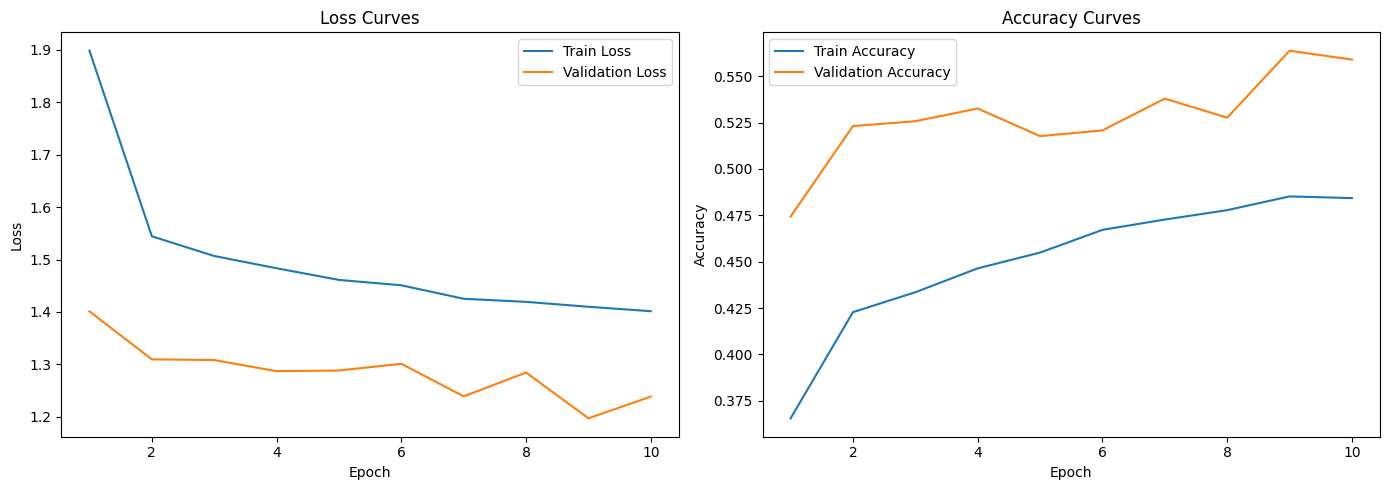

In [30]:
visualisations.plot_acc_loss_curves(results=vgg19_results,validation=True)

In [31]:
test_results = predictions.test_model(model=Vgg19,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5299
Test loss : 1.2985


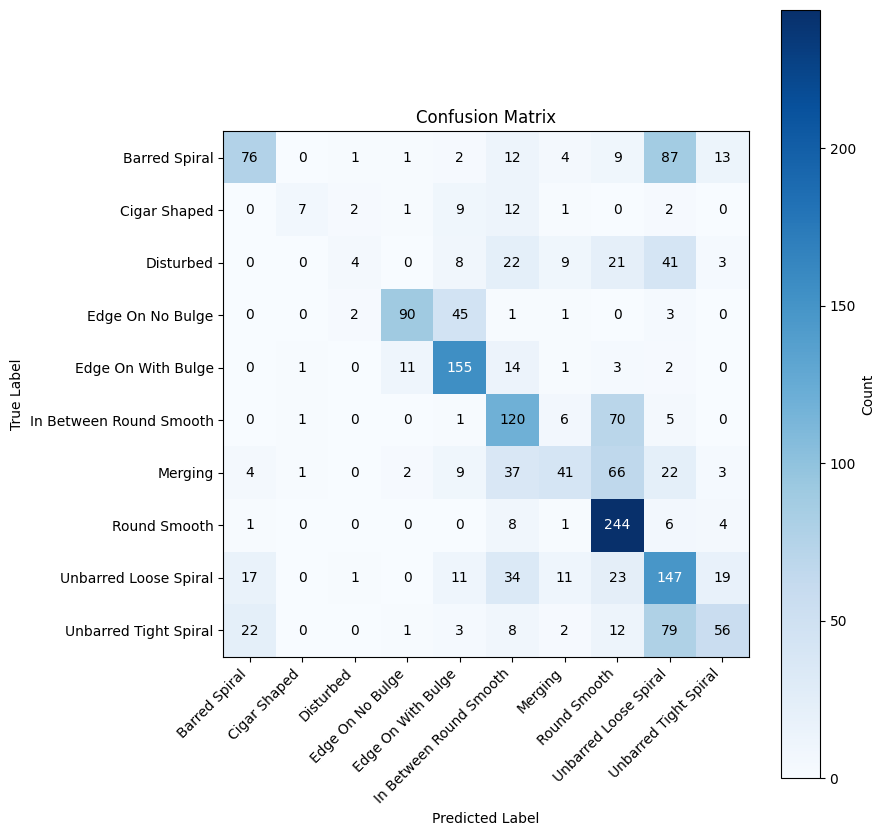

In [32]:
predictions.plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

In [33]:
save_model.save_model(model=ResNet26,model_name="VGG19_10_epochs_trainable_classifier.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/vgg19/VGG19_10_epochs_trainable_classifier.pth


<br>

## Custom CNN

In [5]:
import torch
torch.cuda.empty_cache()


In [7]:
custom_model = custom_cnn.custom_cnn(num_classes=10)

I trained the custom model for around 48 epochs since the returns were diminshing with every extra epoch

In [8]:
custom_model.load_state_dict(torch.load(f="../checkpoints/custom_cnn/CustomCNN_48_epochs.pth"))

<All keys matched successfully>

In [9]:
from torchinfo import summary

summary(
    custom_model,
    input_size=(1, 3, 224, 224)
)

Layer (type:depth-idx)                   Output Shape              Param #
CustomCNN                                [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 5, 5]             --
│    └─Conv2d: 2-1                       [1, 512, 222, 222]        14,336
│    └─ReLU: 2-2                         [1, 512, 222, 222]        --
│    └─MaxPool2d: 2-3                    [1, 512, 111, 111]        --
│    └─Conv2d: 2-4                       [1, 256, 109, 109]        1,179,904
│    └─ReLU: 2-5                         [1, 256, 109, 109]        --
│    └─MaxPool2d: 2-6                    [1, 256, 54, 54]          --
│    └─Conv2d: 2-7                       [1, 128, 52, 52]          295,040
│    └─ReLU: 2-8                         [1, 128, 52, 52]          --
│    └─MaxPool2d: 2-9                    [1, 128, 26, 26]          --
│    └─Conv2d: 2-10                      [1, 128, 24, 24]          147,584
│    └─ReLU: 2-11                        [1, 128, 24, 24]       

In [10]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= dataloaders.create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=transforms.get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=transforms.get_eval_transforms(resize_size=256,crop_size=224),
                                                                        batch_size=16)

In [11]:
optimizer = torch.optim.Adam(params=custom_model.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [12]:
custom_model_results = engine.train(model=custom_model,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7352 | train_acc: 0.7555 | val_loss: 0.7805 | val_acc: 0.7413
Epoch: 2 | train_loss: 0.7121 | train_acc: 0.7581 | val_loss: 0.7154 | val_acc: 0.7499
Epoch: 3 | train_loss: 0.7143 | train_acc: 0.7556 | val_loss: 0.7316 | val_acc: 0.7566
Epoch: 4 | train_loss: 0.7206 | train_acc: 0.7542 | val_loss: 0.6557 | val_acc: 0.7708
Epoch: 5 | train_loss: 0.7017 | train_acc: 0.7600 | val_loss: 0.6655 | val_acc: 0.7860
Epoch: 6 | train_loss: 0.7025 | train_acc: 0.7646 | val_loss: 0.6899 | val_acc: 0.7719
Epoch: 7 | train_loss: 0.6996 | train_acc: 0.7615 | val_loss: 0.7227 | val_acc: 0.7676
Epoch: 8 | train_loss: 0.6902 | train_acc: 0.7646 | val_loss: 0.6543 | val_acc: 0.7821
Epoch: 9 | train_loss: 0.6946 | train_acc: 0.7654 | val_loss: 0.7492 | val_acc: 0.7527
Epoch: 10 | train_loss: 0.7103 | train_acc: 0.7590 | val_loss: 0.7281 | val_acc: 0.7414


In [13]:
save_model.save_model(model=custom_model,model_name="CustomCNN_Pre_Trained_10_epochs.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/custom_cnn/CustomCNN_Pre_Trained_10_epochs.pth


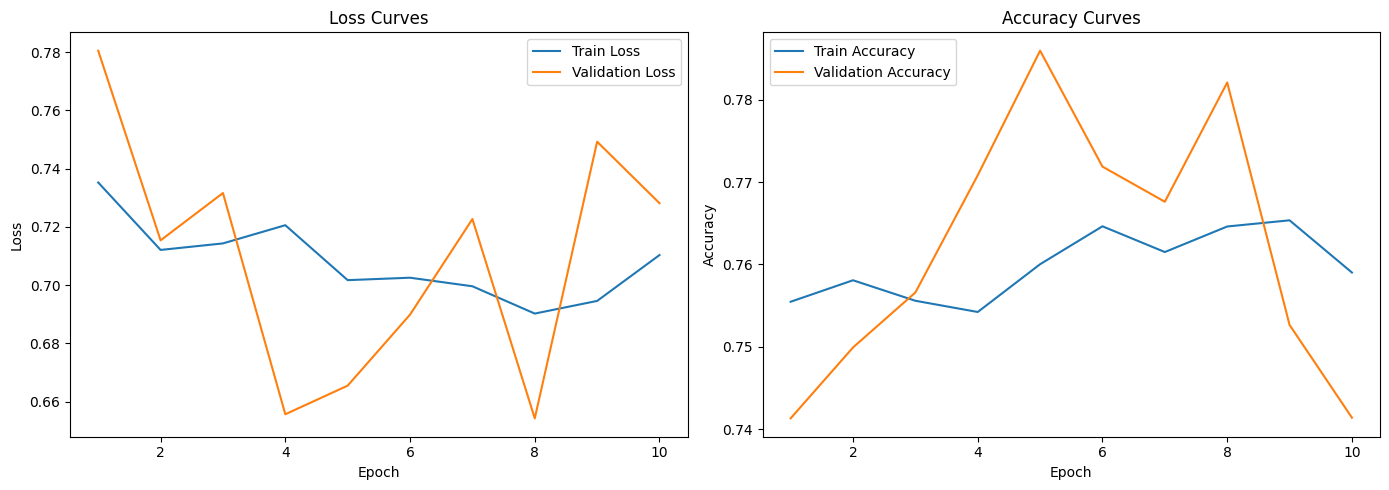

In [14]:
visualisations.plot_acc_loss_curves(results=custom_model_results,validation=True)

In [15]:
test_results = predictions.test_model(model=custom_model,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.7582
Test loss : 0.7446


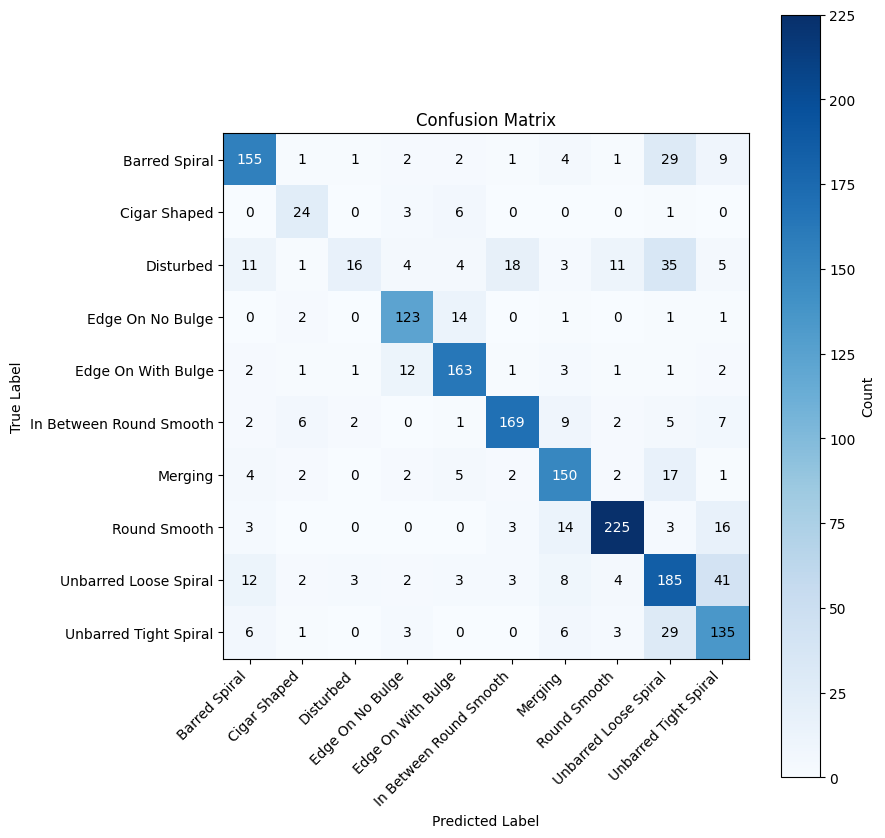

In [16]:
predictions.plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)